# Parameter Estimation for ODE Systems
In this last part of the workshop, we are looking at estimating parameters of ODE Systems. For this task, we will use several packages, in addition to the `DifferentialEquations` package:

* SciMLSensitivity: Computing derivatives of ODE solutions to their parameters
* Optimization: Defining optimization problems and running an optimization
* OptimizationOptimJL: The Optim.jl optimizers for the Optimization package. Includes the BFGS algorithm that we will use

> **About SciMLSensitivity**  
> This package contains automatic differentiation routines for differential equation systems, extending basic automatic differentiation capabilities of Julia. Details on the methods can be found in [Ma et al. (2021)](https://arxiv.org/pdf/1812.01892.pdf)

In [16]:
using DifferentialEquations
using Random
using Plots
using SciMLSensitivity, Optimization, OptimizationOptimJL

We're going to reuse the SIR-model that we defined in the previous part:

$$
\begin{align}
\frac{\mathrm{d}S}{\mathrm{d}t} &= -\beta IS \\
\frac{\mathrm{d}I}{\mathrm{d}t} &= \beta IS - \gamma I \\
\frac{\mathrm{d}R}{\mathrm{d}t} &= \gamma I \\
\end{align}
$$

A compact implementation of this model is given below. This illustrates the ease of defining a differential equation system, simulating and plotting it in Julia.

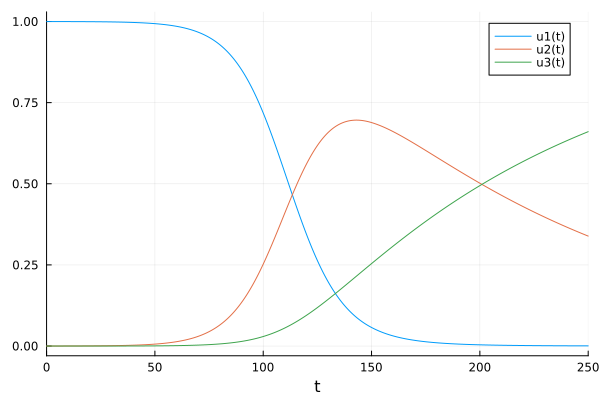

In [17]:
function SIRModel!(du, u, p, t)
  du[1] = -p[1]*u[1]*u[2]
  du[2] = p[1]*u[1]*u[2] - p[2]*u[2]
  du[3] = p[2]*u[2];
end

u0 = [0.9999, 0.0001, 0.]
tspan = (0, 250)
p = [0.09, 0.008]

prob = ODEProblem(SIRModel!, u0, tspan, p, sensealg=ForwardDiffSensitivity())
solution = solve(prob)
plot(solution)

As you see, the model behaves exactly the way we expect. Now we will simulate some data to estimate parameters from. We will use the Random package for adding a slight bit of noise to the data. We use the `max`-function to prevent the values of ending up below zero.

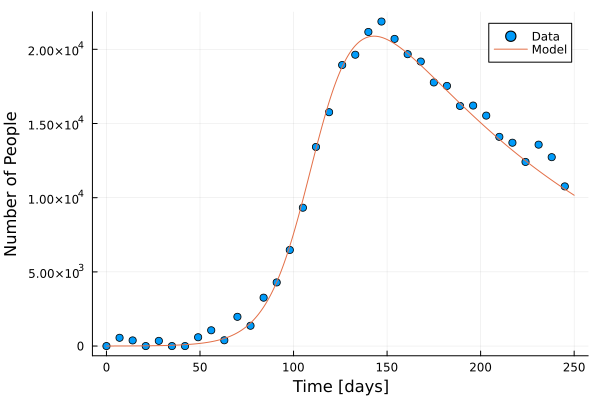

In [18]:
Random.seed!(128)
timepoints = 0:7:250; # measure every week

# population of 30.000
N = 30_000

infected = max.(N .* (Array(solution(timepoints, idxs=2)) + randn(length(timepoints)) .* 0.025), 0)
scatter(timepoints, infected, xlabel = "Time [days]", ylabel = "Number of People", labels="Data")
plot!(0:0.1:250, Array(solution(0:0.1:250, idxs=2)) .* N, labels="Model")

To estimate parameters from this data, we require a loss function. We will define a loss function based on the parameters `p` as follows:

$$\mathcal{L}(p) = \sum_{i=0}^{N_t} \left(I_{\mathrm{data}, i} - I_{\mathrm{model}}(p, t_i)\right)^2$$

Do note that the model defined is based on proportions of the population, which means we need to multiply the model predictions with the total population to obtain the estimate of the number of infected people.

In [19]:
function loss(p) 
  ŷ = Array(solve(prob, p=p, saveat=timepoints))[2,:] .* N # multiply with N because the model gives proportions
  sum(abs2, ŷ - infected)
end

loss (generic function with 1 method)

Something that might have caught your eye is this `sum` function and the way that it's called. This is a specific method of the sum function: `sum(f, x::AbstractArray)` which works as:

$$\text{sum}\left(f, x\right) = \sum_{i=1}^{\text{length}(x)} f(x_i)$$

Now we are ready to define our optimization problem. We first specify our initial parameter guesses and optionally other parameters, such as lower and upper bounds for the parameters. Note that the support for other parameters may differ based on the optimizer chosen (see [Optimization.jl](https://docs.sciml.ai/Optimization/stable/) for more info).

In [20]:
p0 = [0.1, 0.1]
lb = [0., 0.]
ub = [1., 1.]

2-element Vector{Float64}:
 1.0
 1.0

Now Julia requires us to define an optimization function, which combines the loss function with a method used for differentiating this loss function. Specifying an `OptimizationFunction` does require the loss function to be specified slightly differently, as it is expected to have an additional parameter $\lambda$, depicting the hyperparameters of the loss function. In this case, we do not have those, so we define a closure (similar to the `@` in Matlab or the `lambda` in Python) that takes two arguments, but does nothing with the second argument, and just calls the loss function using the first argument. The second argument for our optimization function is `AutoForwardDiff`. The `Auto` means that the optimization function automatically generates the required derivative expressions, while `ForwardDiff` means that we are using the derivative implementations from the `ForwardDiff.jl` library. The details of this computation are less important. A general rule of thumb for which one to use is:
* Small systems (number of parameters $\lt 100$): `AutoForwardDiff()` -> Forward-mode AD: Initially faster, but doesn't scale well
* Large systems (number of parameters $\gt 100$): `AutoZygote()` -> Reverse-mode AD: Slower initially, but scales very well.

The optimization function is then plugged into an optimization problem, where we specify our initial parameter guesses, and optionally lower and upper bounds.

In [24]:

optfunc = OptimizationFunction((x, λ) -> loss(x), Optimization.AutoForwardDiff())
optprob = OptimizationProblem(optfunc, p0, lb=lb, ub=ub)

OptimizationProblem. In-place: true
u0: 2-element Vector{Float64}:
 0.1
 0.1

Finally, we can call `solve` (similar to solving ODEs) and add the optimization method to use, which is `BFGS()` in this case.

In [25]:
optimization_solution = solve(optprob, BFGS())

u: 2-element Vector{Float64}:
 0.08922000410723287
 0.00766450649723009

The returned object is an OptimizationSolution, containing the found parameter values, accessible using `optimization_solution.u` and the objective function (`optimization_solution.objective`), and some other information about the optimization process (call `fieldnames(typeof(optimization_solution))` to show all fields that are in the solution object). Let's investigate how well we did, and plot the solution:

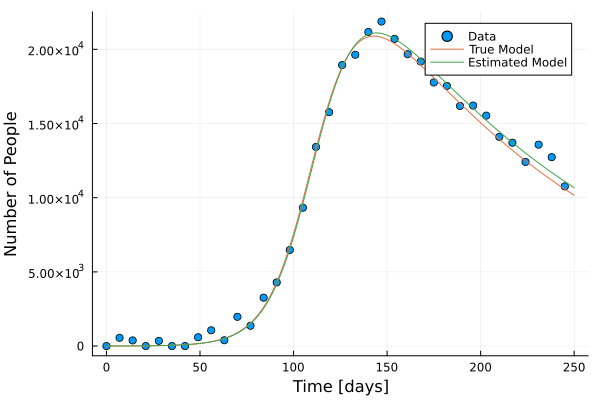

In [9]:

estimated_infections = Array(solve(prob, p=optimization_solution.u, saveat=0:0.1:250))[2,:] .* N

scatter(timepoints, infected, xlabel = "Time [days]", ylabel = "Number of People", labels="Data")

plot!(0:0.1:250, Array(solution(0:0.1:250, idxs=2)) .* N, labels="True Model")
plot!(0:0.1:250, estimated_infections, labels="Estimated Model")

---
Exercise 1
---

Simulate some new data, varying the amount of noise you add. Can you make a plot of the objective function value versus the amount of noise that you add?

In [ ]:
# Exciting things to appear here!

---

## Structural Identifiability Analysis
A cool feature of ModelingToolkit, is the automatic structural identifiability analysis. We can import this with `StructuralIdentifiability`. For this, we first need to define our model using `ModelingToolkit`. 

> There is currently a bug in StructuralIdentifiability, which prevents using Greek symbols in the ModelingToolkit model. Therefore, we use the names of the greek symbols. ModelingToolkit will parse them as Greek symbols anyway,  while StructuralIdentifiability will remain working

In [42]:
using ModelingToolkit, StructuralIdentifiability

@variables t S(t) I(t) R(t) Y(t)
@parameters beta gamma
d = Differential(t) 

equations = [
  d(S) ~ -beta*S*I,
  d(I) ~ beta*S*I - gamma*I,
  d(R) ~ gamma*I
]

sirsystem = ODESystem(equations, t, name = :SIRModel)

Model SIRModel with 3 equations
States (3):
  S(t)
  I(t)
  R(t)
Parameters (2):
  beta
  gamma

We then define an array of measured quantities. In the `@variables` macro, we added an extra variable `Y(t)`, which is our measurement. In the measured quantities array, we can define the correspondence between a measurement and the model state variables. In this case, our measurement directly corresponds to `I`. We then call the `assess_identifiability` function on the system and specify the measured quantities. We then see that it starts computing and shows that all of our parameters are globally identifiable.

In [49]:
measured_quantities = [Y ~ I]
sir_identifiability = assess_identifiability(sirsystem, measured_quantities=measured_quantities)

┌ Info: Preproccessing `ModelingToolkit.AbstractTimeDependentSystem` object
└ @ StructuralIdentifiability /Users/max/.julia/packages/StructuralIdentifiability/rYPpk/src/ODE.jl:495
┌ Info: Assessing local identifiability
└ @ StructuralIdentifiability /Users/max/.julia/packages/StructuralIdentifiability/rYPpk/src/StructuralIdentifiability.jl:107
┌ Info: Local identifiability assessed in 0.00331475 seconds
└ @ StructuralIdentifiability /Users/max/.julia/packages/StructuralIdentifiability/rYPpk/src/StructuralIdentifiability.jl:111
┌ Info: Assessing global identifiability
└ @ StructuralIdentifiability /Users/max/.julia/packages/StructuralIdentifiability/rYPpk/src/StructuralIdentifiability.jl:128
┌ Info: Note: the input model has nontrivial submodels. If the computation for the full model will be too heavy, you may want to try to first analyze one of the submodels. They can be produced using function `find_submodels`
└ @ StructuralIdentifiability /Users/max/.julia/packages/StructuralIdentifi

Dict{SymbolicUtils.BasicSymbolic{Real}, Symbol} with 2 entries:
  gamma => :globally
  beta  => :globally

---
Exercise 2
---

Investigate the identifiability for the model if we instead would have measured:
* only `R`
* only `S`
* only the infection force (`beta * I`)

Explain whether these results are expected.


In [ ]:
# I'm curious what will be written here!

---

# Practical: Model Building and Parameter Estimation
Epidemia is a small country with five cities and a total population of 14,771 people. One of them has become mysteriously ill, starting an epidemic across the whole country. The epidemic control organization issues all citizens who feel ill to prevent contact with others. However, the disease has a short period where it can transmit to others, while the carrier is not feeling ill yet. 

To combat this epidemic, all citizens are tested every three days, and the resulting number of infections are collected.

Nevertheless, the citizens of Epidemia are stubborn, and only trust their own feelings, and not some government test. Therefore, all citizens remain involved in their daily activities, unless they are feeling ill, at which point they will isolate as much as possible, to reduce the transmission.

The disease also has the ability to reinfect those who have already had it previously, but due to an excellent immune system, this reinfection probability is low.

## The data
The file `datasets/epidemic.csv` contains the results from the government testing, including the total amount of tests conducted. You can assume that every live citizen (stubborn as they may be) has been tested, making the amount of tests conducted a good estimate of the amount of people still alive.

## The Practical Exercise
1. Load the data from the file specified above, and visualize it.
2. Implement a SIR Model with extensions, and try to estimate the parameters of this model using the data. 
3. Use the StructuralIdentifiability package to test the identifiability of your model parameters, given the data. 
4. Repeat 2 and 3 until you have found a globally identifiable model that is able to properly explain the data

### Optional Exercise
5. In a parallel universe, the conditions are exactly the same as described above, except the immune systems of the people of Epidemia are slightly weaker, resulting in a much heavier pandemic, with multiple waves and a much higher final infection count. Try to fit the model you developed previously to the data in `datasets/epidemic_2.csv`, but only estimate a single model parameter.

In [8]:
# Start here! Good luck!